In [1]:
import numpy as np
import torch as torch
import torch.nn as nn
import matplotlib.pyplot as plt
import copy
#from saga import SAGA
from torch.optim.optimizer import Optimizer, required
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [2]:
import torch
import copy
from torch.optim.optimizer import Optimizer, required

class SAGA(Optimizer):
    def __init__(self, params,model, n_samples=required, lr=required, initial_gradients = None):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        defaults = dict(lr=lr, initial_gradients = initial_gradients)
        super(SAGA, self).__init__(params, defaults)
        #initialize avg and past gradients to 0
        if initial_gradients is None:
            #copy entire model for now
            self.avg_gradients = self.init_params(copy.deepcopy(model))
            self.past_gradients = [self.init_params(copy.deepcopy(model)) for i in range(n_samples)]
        else:
            #to implement
            pass
        self.n_samples = n_samples #to add to defaults

    def __setstate__(self, state):
        super(SAGA, self).__setstate__(state)
        
    def init_params(self,model):
        for param in model.parameters():
            param.data.fill_(0)
        return model

    #use closer to get index of random example for now
    def step(self, closure=None):
        loss = None
        if closure is None:
            raise ValueError("Need index of example")

        idx = closure
        #param_groups assumed to have only 1 group for now
        for group in self.param_groups:
            for (p,past_grad,avg_grad) in zip(group['params'],self.past_gradients[idx].parameters(),self.avg_gradients
                                              .parameters()):
                if p.grad is None:
                    continue
                d_p = p.grad.data - past_grad.data + avg_grad.data
                avg_grad.data += (p.grad.data - past_grad.data)/self.n_samples
                past_grad.data = p.grad.data.clone()
                p.data.add_(-group['lr'], d_p)

        return loss

In [3]:
IN_DIM = 40000
OUT_DIM = 1
N_SAMPLES = 500
NOISE = 40000
CLUSER_DIST = 4

In [4]:
def generate_data(n_samples = 200, x_dim = 3,noise = 3, cluster_distance = 0):
    #generate two clusters of data, where points will most often correspond to a class
    x1 = np.full((int(n_samples/2),x_dim),-(cluster_distance/2))
    x2 = np.full((int(n_samples/2),x_dim),cluster_distance/2)
    X = np.r_[x1,x2].astype(np.float32)
    X += 2*(np.random.rand(n_samples,x_dim)-0.5).astype(np.float32)
    coefs = np.random.permutation(x_dim)
    y = noise*np.random.randn(n_samples,1)
    for i in range(x_dim):
        # y is linear combination of x, with noise added
        y += (1/x_dim)*coefs[i]*X[:,i].reshape(-1,1)
    y = y > 0
    y = y.reshape(-1,1).astype(np.float32)
    return X,y

In [5]:
X,y = generate_data(N_SAMPLES,IN_DIM,NOISE, CLUSER_DIST)
X = (X-X.mean(axis=0))/X.std(axis = 0)

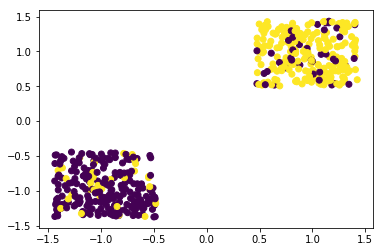

In [6]:
plt.scatter(X[:,0],X[:,1],c = y)

In [7]:
y.mean()

0.48800001

In [8]:
class LR(nn.Module):
    def __init__(self,IN_DIM,OUT_DIM):
        super(LR, self).__init__()
        self.linear = torch.nn.Linear(IN_DIM, OUT_DIM) # 2 in and 1 out
        
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

In [9]:
model_GD = LR(IN_DIM,OUT_DIM)
model_SGD = LR(IN_DIM,OUT_DIM)
model_SAGA = LR(IN_DIM,OUT_DIM)
model_GD_losses = []
model_SGD_losses = []
model_SAGA_losses = []

criterion = nn.BCELoss()
lr = 0.0001
optimizer_GD = torch.optim.SGD(model_GD.parameters(), lr = lr)
optimizer_SGD = torch.optim.SGD(model_SGD.parameters(), lr = lr)
optimizer_SAGA = SAGA(model_SAGA.parameters(),model_SAGA, X.shape[0], lr = lr)

n_epochs = 8000

In [10]:
def plot_loss(losses, labels):
    plt.figure(figsize=(15,5))
    for losses, label in zip(losses, labels):
        plt.plot(losses, label = label)
    plt.legend(loc='upper right')
    plt.title('training loss (lr: {}, in_dim: {}, noise = {}, n_samples = {}, cluster dist: {})'.format(
    lr,IN_DIM,NOISE,N_SAMPLES,CLUSER_DIST))
    plt.xlabel('iteration')
    plt.ylabel('loss')

In [11]:
#train GD
for epoch in range(n_epochs):
    inputs = torch.from_numpy(X)
    labels = torch.from_numpy(y)
    
    outputs = model_GD.forward(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer_GD.step()
    model_GD_losses.append(loss.data.item())
    optimizer_GD.zero_grad()

In [12]:
#train SGD
for epoch in range(n_epochs):
    idx = np.random.randint(X.shape[0])  # get random sample index
    inputs = torch.from_numpy(X)[idx]
    labels = torch.from_numpy(y)[idx]
    inputs_loss_plot = torch.from_numpy(X) # to compute mean loss
    labels_loss_plot = torch.from_numpy(y) # to compute mean loss

    outputs = model_SGD.forward(inputs)
    outputs_loss_plot = model_SGD.forward(inputs_loss_plot)
    loss = criterion(outputs, labels)
    loss_plot = criterion(outputs_loss_plot, labels_loss_plot)
    loss.backward()
    optimizer_SGD.step()
    model_SGD_losses.append(loss_plot.data.item())
    optimizer_SGD.zero_grad()

In [13]:
#train SAGA
for epoch in range(n_epochs):
    idx = np.random.randint(X.shape[0]) # get random sample index
    inputs = torch.from_numpy(X)[idx]
    labels = torch.from_numpy(y)[idx]
    inputs_loss_plot = torch.from_numpy(X)
    labels_loss_plot = torch.from_numpy(y)

    outputs = model_SAGA.forward(inputs)
    outputs_loss_plot = model_SAGA.forward(inputs_loss_plot)
    loss = criterion(outputs, labels)
    loss_plot = criterion(outputs_loss_plot, labels_loss_plot)
    loss.backward()
    closure = idx
    optimizer_SAGA.step(closure)
    model_SAGA_losses.append(loss_plot.data.item())
    optimizer_SAGA.zero_grad()

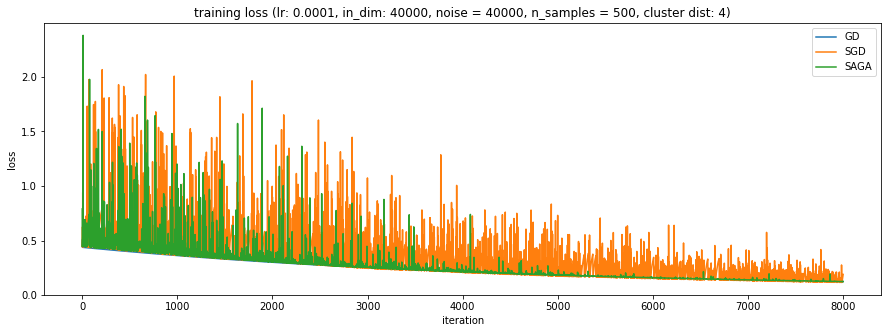

In [14]:
plot_loss([model_GD_losses,model_SGD_losses,model_SAGA_losses], ['GD','SGD','SAGA'])